In [ ]:
#TODO : REFACTOR
import numpy as np
np.random.seed(42)
import sklearn
import os
#import helper
import keras
import pickle
import math
import collections
from sklearn.metrics import confusion_matrix

from keras.layers.advanced_activations import LeakyReLU 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import matplotlib.pyplot as plt
import random
import statistics
%matplotlib inline
import pandas as pd

from tqdm import tqdm

from keras.regularizers import l2

import random
import csv
from tensorflow.contrib.layers import flatten
from skimage import transform as transf

import loader
import preprocess
import plotter


#from prettytable import PrettyTable
%matplotlib inline

SEED = 22

In [ ]:
X_train, y_train, X_test, y_test,X_val,y_val = loader.load_split_input_data()


In [ ]:
X_train_g, X_test_g,X_val_g = preprocess.convert_to_grayscale(X_train, X_test,X_val)
X_train_h, X_test_h, X_val_h = preprocess.hist_equalize_set(X_train_g, X_test_g, X_val_g)
#X_train_n, X_test_n,X_val_n = preprocess.noralize(X_train_g, X_test_g,X_val_g)
X_train_hae ,X_test_hae, X_val_hae = preprocess.adaptive_equalize_set(X_train_h, X_test_h, X_val_h)
X_train_hcs,X_test_hcs,X_val_hcs = preprocess.contrast_stretch_set(X_train_h,X_test_h,X_val_h)



In [3]:
X_train_h,y_train,X_test_h,y_test,X_val_h,y_val,X_aug_h,y_aug_h = loader.load_preprocessed_data("./preprocessed/preprocessed_hist_gray.p")
X_train_hae,y_train,X_test_hae,y_test,X_val_hae,y_val,X_aug_hae,y_aug_hae = loader.load_preprocessed_data("./preprocessed/preprocessed_hae_gray.p")
X_train_hcs,y_train,X_test_hcs,y_test,X_val_hcs,y_val,X_aug_hcs,y_aug_hcs = loader.load_preprocessed_data("./preprocessed/preprocessed_hcs_gray.p")


./preprocessed/preprocessed_hist_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.
./preprocessed/preprocessed_hae_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.
./preprocessed/preprocessed_hcs_gray.p
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.


In [4]:
def combine_datasets(datasets):

    x=datasets[0][0]
    y = datasets[0][1]
    
    if type(x) is list:
            x = np.asarray(x)
            print(str(count)+' is a list')
    if type(y) is list:
            y = np.asarray(y)
        
    #print(x.shape)
    #print(y.shape)
    X_all=x
    y_all=y
    print('combining dataset '+str(0)+' of type '+str(type(x))+' and length '+str(len(x)))
            
    count = 0
    for ds in datasets:
        if count==0: #since we added the first one already
            count+=1
            continue
       
        #print(type(ds))
        x = ds[0]
        y=ds[1]
        print('combining dataset '+str(count)+' of type '+str(type(x))+' and length '+str(len(x)))
        if type(x) is list:
            x = np.asarray(x)
            print('Dataset '+str(count)+' is a list; converting to  ndarray')
        if type(y) is list:
            y = np.asarray(y)
        
        

        X_all=np.append(X_all,x,axis=0)
        y_all=np.append(y_all,y,axis=0)
        count+=1


   
    assert(len(X_all) == len(y_all))
    print('length of combined set : '+str(len(X_all)))
    return np.asarray(X_all),np.asarray(y_all)


    
    
    
#X_all,y_all=combine_datasets([(X_train_h,y_train),(X_train_hae,y_train),(X_train_hcs,y_train)(X_train_n,y_train)])
X_all,y_all=combine_datasets([(X_train_h,y_train),(X_train_hae,y_train),(X_train_hcs,y_train)])
     

combining dataset 0 of type <class 'numpy.ndarray'> and length 34799
combining dataset 1 of type <class 'numpy.ndarray'> and length 34799
combining dataset 2 of type <class 'list'> and length 34799
Dataset 2 is a list; converting to  ndarray
length of combined set : 104397


In [ ]:
def data_augment(X,y,n_classes,n_gen_per_class,n_aug_per_class):

    print('Generating '+str(n_gen_per_class)+' number of images per class, selecting '+str(n_aug_per_class)+' number of images per class for  augmentation')
    
    datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
   # horizontal_flip=True,
    )

    
    img_shape = [X.shape[1], X.shape[2], X.shape[3]]
    img_shape.insert(0,0)
    
    data_shape = np.asarray(img_shape)
    total_image_per_class = n_gen_per_class
    
    X_augmented =np.empty(data_shape)
    y_augmented =np.empty(0,dtype='uint8')
    


    print('Augmenting  Data...')
    for i in tqdm(range(n_classes)):
    #for i in tqdm(range(3)):
            #print(i)
            index = [y==i]
            images_for_i_class = X[y==i]
            y_i_class = y[y==i]
            X_augmented_i = np.empty(data_shape)
            #print(X_augmented_i.shape)
            y_augmented_i = np.empty(0,dtype='uint8')
            for X_b,y_b in datagen.flow(images_for_i_class, y_i_class, batch_size=len(y_i_class), seed=9345+i*37):            
                X_augmented_i = np.append(X_augmented_i, X_b, axis=0)
                y_augmented_i = np.append(y_augmented_i, y_b, axis=0)

                if len(X_augmented_i) >= total_image_per_class:
                    break
            X_augmented_i, y_augmented_i = shuffle(X_augmented_i, y_augmented_i, random_state=9345)
            X_augmented = np.append(X_augmented, X_augmented_i[:n_aug_per_class], axis=0)
            y_augmented = np.append(y_augmented, y_augmented_i[:n_aug_per_class], axis=0)     
    print("shufle")
    X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=9345)
    print("X_augmented shape: "+str(X_augmented.shape))
    print("y_augmented shape: "+str(y_augmented.shape))
    return X_augmented, y_augmented
    
    # Storing for checkpoint2
    #X_augmented = X_augmented.astype('float32')

    


In [6]:


X_aug_all, y_aug_all = preprocess.data_augment(X_all,y_all,n_classes=43,n_gen_per_class=1000,n_aug_per_class=200)
print(X_aug_all.shape)
print(y_aug_all.shape)


Generating 1000 number of images per class, selecting 200 number of images per class for  augmentation
Augmenting  Data...



100%|██████████| 43/43 [00:25<00:00,  2.93it/s]


shufle
X_augmented shape: (8600, 32, 32, 1)
y_augmented shape: (8600,)
(8600, 32, 32, 1)
(8600,)


In [15]:
from imp import reload

loader = reload(loader)

loader.save_to_disk(X_all,y_all,X_test_hae,y_test,X_val_hae,y_val,X_aug_all,y_aug_all,False,"hset_aug")

#save_aug_all_to_disk(X_aug_all,y_aug_all)

preprocessed/preprocessed_hset_aug_gray.p
Saving data to preprocessed/preprocessed_hset_aug_gray.p file...
Data cached in preprocessed/preprocessed_hset_aug_gray.p


In [16]:
X_all,y_all,X_test_hae,y_test,X_val_hae,y_val,X_aug_all,y_aug_all = loader.load_preprocessed_data("./preprocessed/preprocessed_hset_aug_gray.p")

./preprocessed/preprocessed_hset_aug_gray.p
X_train:  104397
y_train:  104397
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
X_aug:  8600
y_aug:  8600
Data and modules loaded.


In [17]:
X_aug_all,y_aug_all=combine_datasets([(X_all,y_all),(X_aug_all,y_aug_all)])

combining dataset 0 of type <class 'numpy.ndarray'> and length 104397
combining dataset 1 of type <class 'numpy.ndarray'> and length 8600
length of combined set : 112997
Augmented Combined Datasets:112997
Combined Datasets:104397


In [25]:
#y_train_e = np_utils.to_categorical(y_train,num_classes=43)

n_classes = 43

y_all_e = np_utils.to_categorical(y_all,num_classes=n_classes)
y_aug_all_e = np_utils.to_categorical(y_aug_all,num_classes=n_classes)
y_test_e = np_utils.to_categorical(y_test, num_classes=n_classes)
y_val_e = np_utils.to_categorical(y_val, num_classes=n_classes)

In [23]:
#load models
from keras.models import load_model
import Models 

Models = reload(Models)

#model_deep= load_model('deep_cnn_89_all_aug_on_hae.h5',custom_objects={'STN':SpatialTransformer})

model = Models.deep_cnn_model(flag_BN=True,flag_STN=True)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.load_weights('weights_deep_cnn_98.hdf5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        32        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
__________

In [92]:
print("evaluating")
evaluate= model.evaluate(X_test_hae,y_test_e,verbose=False)

prob = model.predict(X_test_hae)
predictions = np.argmax(prob, axis=1)
#print(predictions)

evaluating


Incorrect predictions:  238


In [38]:
import collections
# Read .csv file:
class_stats = pd.read_csv('signnames.csv')
#print(sign_names)
num_classes = len(sign_names)


assert (num_classes == n_classes), '1 or more class(es) not represented in training set'


# Count samples in each class, hash

df_test = pd.DataFrame.from_dict(collections.Counter(y_test), orient='index').reset_index()
df_train = pd.DataFrame.from_dict(collections.Counter(y_all), orient='index').reset_index()

df_train = df_train.rename(columns={'index':'ClassId', 0:'NumTrain'})
df_test = df_test.rename(columns={ 'index':'ClassId',0:'NumTest'})

class_stats['NumTrain'] = df_train['NumTrain']
class_stats['NumTest'] = df_test['NumTest']



In [106]:
error_indices = np.where(predictions!=y_test)[0]
#print(error_indices)
numErrors = error_indices.shape[0]
print ("No of wrong predictions: ", numErrors)
error_classes = [y_test[i] for i in error_indices]
df_error_truth = pd.DataFrame.from_dict(collections.Counter(error_classes), orient='index')
#print(df_error_truth)

#print((df_errors).shape)
df_error_truth = df_error_truth.rename(columns={0:'Errors'})
#print(df_errors)

class_stats['Errors'] = df_error_truth['Errors']
class_stats.fillna(value=0, inplace=True)
class_stats['Error%'] = ((class_stats['Errors']/class_stats['NumTest'])*100).round(2)
class_stats['Error%Train'] = ((class_stats['Errors']/class_stats['NumTrain'])*100).round(2)


#print(sum(class_stats['Errors']))

No of wrong predictions:  238


In [107]:
class_stats[['ClassId','SignName','NumTest','Errors','Error%']].head(n=43)

,ClassId,SignName,NumTest,Errors,Error%
0,0,Speed limit (20km/h),60,0.0,0.00
1,1,Speed limit (30km/h),720,3.0,0.42
2,2,Speed limit (50km/h),750,6.0,0.80
3,3,Speed limit (60km/h),450,12.0,2.67
4,4,Speed limit (70km/h),660,4.0,0.61
5,5,Speed limit (80km/h),630,12.0,1.90
6,6,End of speed limit (80km/h),150,4.0,2.67
7,7,Speed limit (100km/h),450,0.0,0.00
8,8,Speed limit (120km/h),450,24.0,5.33
9,9,No passing,480,0.0,0.00


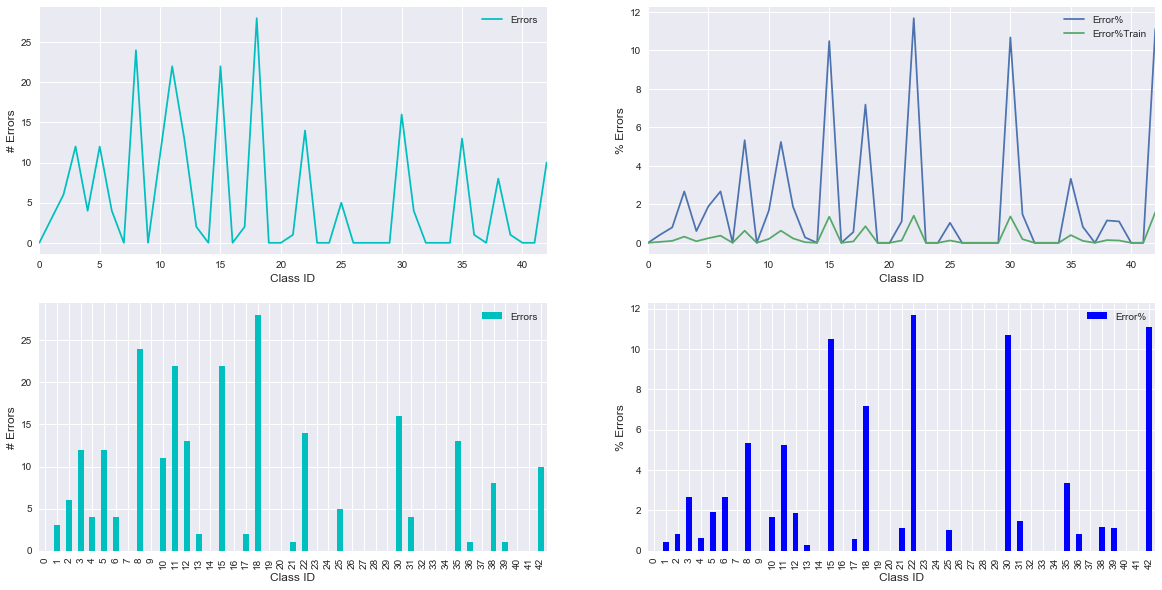

In [219]:



fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2,nrows=2,figsize=(20, 10), sharey=False)


class_stats[['Errors']].plot(ax=ax2,kind='bar',color = 'c')
class_stats[['Error%']].plot(ax=ax3,kind='bar',color = 'b')
class_stats[['Errors']].plot(ax=ax0,kind='line',color = 'c')
class_stats[['Error%','Error%Train']].plot(ax=ax1,kind='line')


ax0.set_xlabel('Class ID', fontsize=12)
ax0.set_ylabel('# Errors', fontsize=12)

ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('% Errors', fontsize=12)


ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('# Errors', fontsize=12)

ax3.set_xlabel('Class ID', fontsize=12)
ax3.set_ylabel('% Errors', fontsize=12)

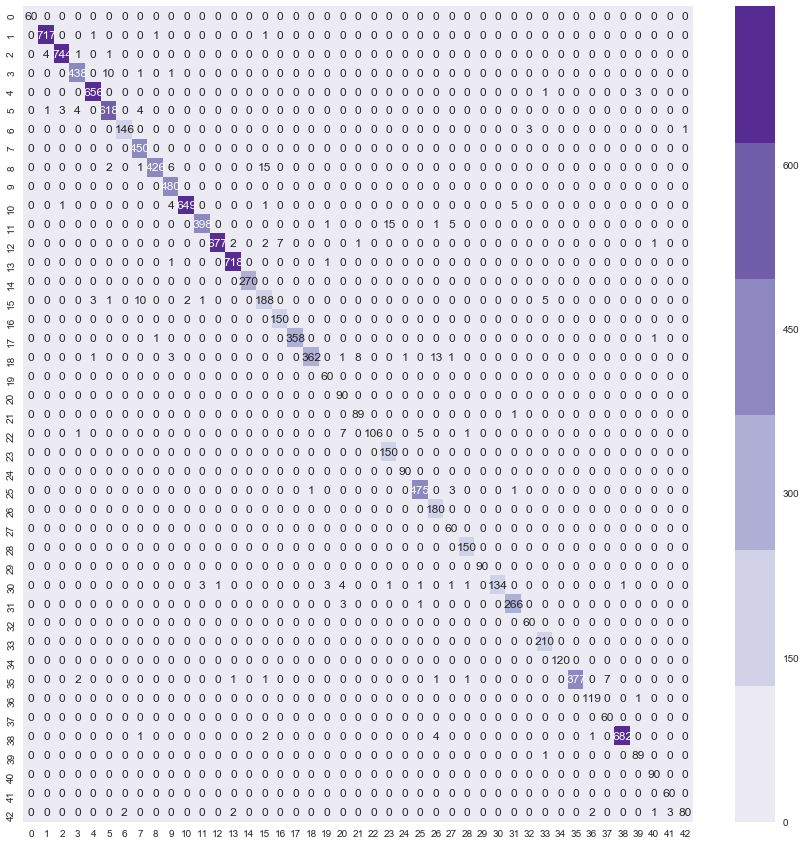

In [175]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches

palette = sns.color_palette('Purples')

cm = confusion_matrix(y_test, predictions)
colormap = ListedColormap(palette.as_hex())


ax = sns.heatmap(cm,annot=True, fmt="d", ax=ax,cmap=colormap)

    

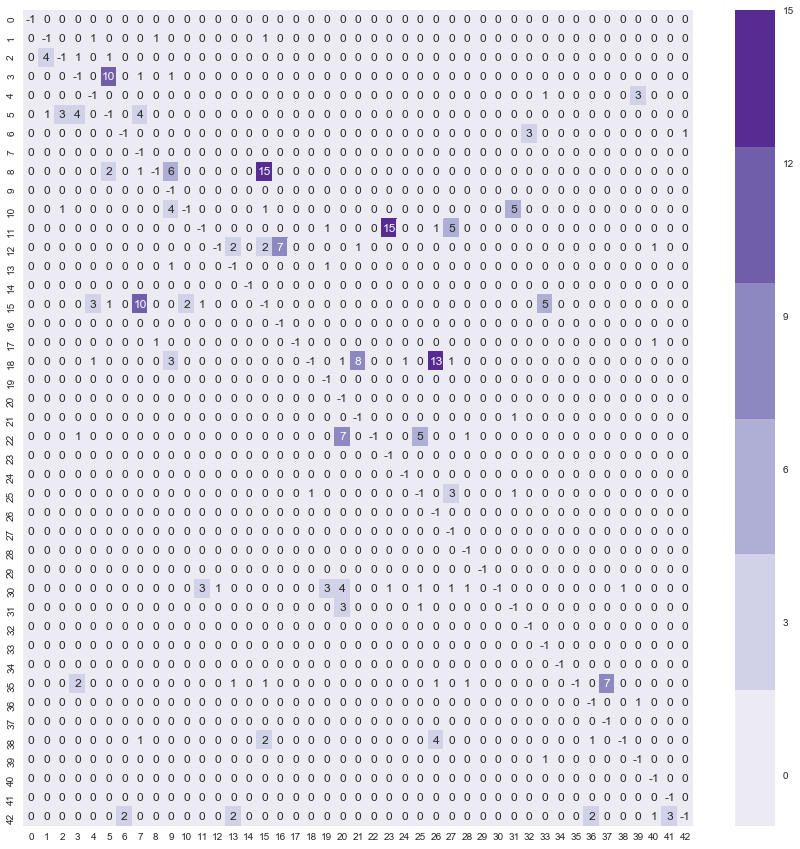

In [212]:

from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches

palette = sns.color_palette('Purples')

cm = confusion_matrix(y_test, predictions)
colormap = ListedColormap(palette.as_hex())


np.fill_diagonal(cm,-1)

ax = sns.heatmap(cm,annot=True, fmt="d", ax=ax,cmap=colormap)

    
   

In [218]:

#df = sklearn.metrics.classification_report( labels=None, target_names=None, sample_weight=None, digits=2)
df1 = sklearn.metrics.precision_recall_fscore_support(y_test, predictions, labels=None, average=None,  sample_weight=None)
class_stats["F1"] = df1[2]
class_stats["Precision"] = df1[0]
#print(class_stats)

np.fill_diagonal(cm,0)

max_misclassified_class =  np.argmax(cm, axis=1)
print(max_misclassified_class)
max_misclassified_class_errors =  np.amax(cm, axis=1)
#print(max_misclassified_class)
class_stats["Max_Misclassified_as"]=max_misclassified_class
print(class_stats.values[3])
class_stats["Max_Misclassified_Class_%"] = (max_misclassified_class_errors/(class_stats["NumTest"]-class_stats["Errors"]))*100

class_stats[["ClassId","F1","Precision","Max_Misclassified_as","Max_Misclassified_Class_%"]].head(n=43)
 


[ 0  4  1  5 39  3 32  0 15  0 31 23 16  9  0  7  0  8 26  0  0 31 20  0  0
 27  0  0  0  0 20 20  0  0  0 37 39  0 26 33  0  0 41]
[3 'Speed limit (60km/h)' 3780 450 12.0 2.67 0.32 0.9776785714285715
 0.9820627802690582 5 2.28310502283105]


,ClassId,F1,Precision,Max_Misclassified_as,Max_Misclassified_Class_%
0,0,1.000000,1.000000,0,0.000000
1,1,0.994452,0.993075,4,0.139470
2,2,0.993324,0.994652,1,0.537634
3,3,0.977679,0.982063,5,2.283105
4,4,0.993187,0.992436,39,0.457317
5,5,0.979398,0.977848,3,0.647249
6,6,0.979866,0.986486,32,2.054795
7,7,0.981461,0.963597,0,0.000000
8,8,0.970387,0.995327,15,3.521127
9,9,0.984615,0.969697,0,0.000000


Speed limit (60km/h) :


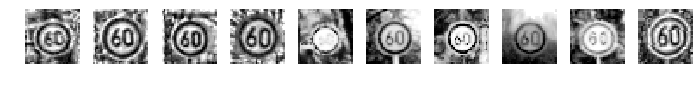

was misclassified as:
Speed limit (80km/h) :


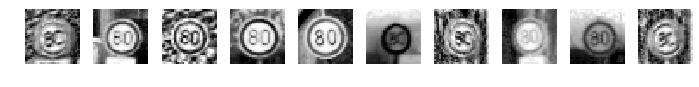

General caution :


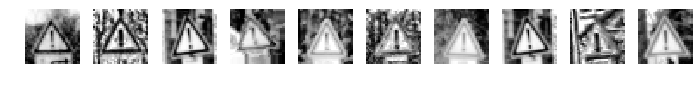

was misclassified as:
Traffic signals :


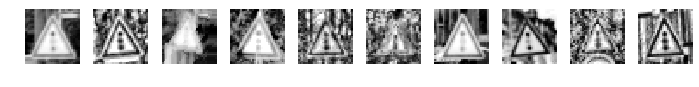

Right-of-way at the next intersection :


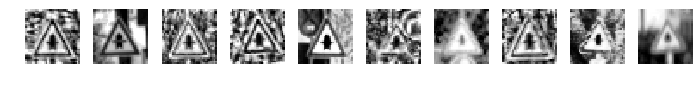

was misclassified as:
Slippery road :


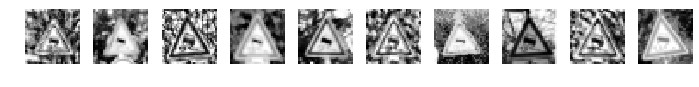

Bumpy road :


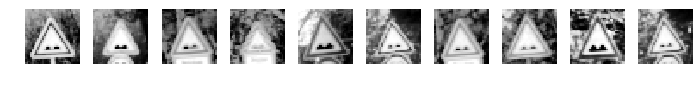

was misclassified as:
Dangerous curve to the right :


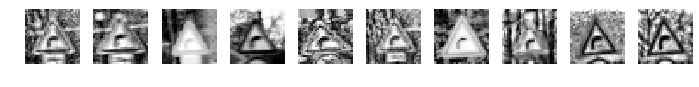

End of no passing by vechiles over 3.5 metric tons :


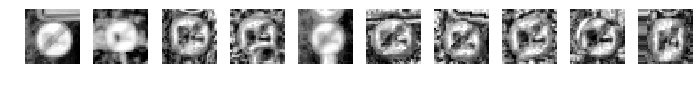

was misclassified as:
End of no passing :


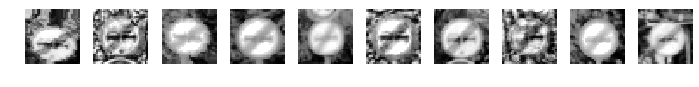

In [234]:

study_range = [3, 5, 18, 26, 11, 23, 22, 20, 42, 41]
compare = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
implot = plt.figure(figsize=(12,4))
counter = 0
for classid in study_range:
    print (class_stats.SignName[classid],':')
    implot = plt.figure(figsize=(12,1))
    X_class = X_aug_all[y_aug_all==classid]
    #rnd_idx = np.random.random(range(len(X_class)), 10)
    rnd_idx=np.random.randint(0, high=len(X_class), size=10)

    for i in range(10):
        ax = implot.add_subplot(1,10,i + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(X_class[rnd_idx[i]].squeeze(),cmap='gray')
    plt.show()
    if compare[counter]:
        print ('was misclassified as:')
    counter += 1


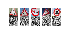

In [402]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

# http://electronicimaging.spiedigitallibrary.org/data/journals/electim/927109/jei_22_4_041105_f010.png

image1 = mpimg.imread('external-data/no-entry.png')
#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plotter.plot_image(image, 1, 3, 0)


image2 = mpimg.imread('external-data/right-turn.png')
#print('This image is:', type(image), 'with dimesions:', image.shape)
#plot_image(image, 1, 3, 0)
actual.append([33, image])

image3 = mpimg.imread('external-data/20kmph.png')
#plot_image(image, 1, 3, 0)
actual.append([0, image])

image4 = mpimg.imread('external-data/children-crossing.png')
#plot_image(image, 1, 3, 0)
actual.append([28, image])

image5 = mpimg.imread('external-data/stop.png')
#plot_image(image, 1, 3, 0)
actual.append([14, image])

image6 = mpimg.imread('external-data/no-truck-passing.png')
#plot_image(image, 1, 3, 0)
actual.append([10, image])
X_test_new = [image1, image2, image3, image4, image5, image6]
y_test_new = [17,33,0,28,14,10]

In [403]:
from skimage import color, exposure, transform

def resize_data(data):
    print(np.asarray(data).shape)
    resize=[]
    # Histogram normalization in v channel
    for img in np.asarray(data):
        #print(img.shape)
        # central square crop
        
        # rescale to standard size
        img = transform.resize(img, (32, 32,3))
        import numpy, itertools


        #for i, j, k in itertools.product(*map(xrange, img.shape)):
        #img[k,i,j] = img [i,j,k]

        # roll color axis to axis 0
        #img = np.rollaxis(img, -1)
        resize.append(img)

    return np.asarray(resize)


#preprocess = reload(preprocess)
X_test_new_orig = np.copy(X_test_new)

#X_test_new = read_all_imgs()
X_test_new = resize_data(X_test_new)
print(X_test_new.shape)

X_test_new= preprocess.conv_to_grayscale_data(np.asarray(X_test_new))
X_test_new = preprocess.hist_equalize(X_test_new)
X_test_new = preprocess.adaptive_equalize(X_test_new)
#X_test_new = preprocess.contrast_stretch(X_test_new)


(6, 90, 89, 4)


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(6, 32, 32, 3)


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 6/6 [00:00<00:00, 72.50it/s]


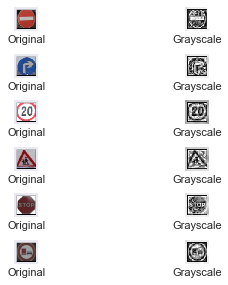

In [404]:

plotter.plot_2_datasets(X_test_new_orig.squeeze(),X_test_new.squeeze(),"Original", "Grayscale")

In [372]:
print(X_test_new.shape)

(6, 32, 32, 1)


TypeError: Cannot handle this data type

In [373]:

prob_new = model.predict(X_test_new)
new_preds = np.argmax(prob, axis=1)

#test_new_class = np.argmax(X_test_new, axis=1)
print(new_preds.shape)


(6,)


No entry:17
Turn right ahead:33
Speed limit (20km/h):0
Pedestrians:27
Speed limit (80km/h):5
No passing for vechiles over 3.5 metric tons:10


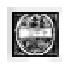

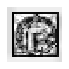

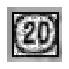

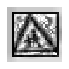

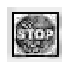

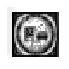

In [376]:
for i in range(len(new_preds)):
    print (class_stats.SignName[new_preds[i]]+':'+str(class_stats.ClassId[new_preds[i]]))
    plotter.plot_image(X_test_new[i].squeeze(), 1, 6, 0)

    

In [400]:
print (y_test_new)
print(new_preds)

[17, 33, 0, 28, 14, 10]
[17 33  0 27  5 10]


In [401]:
#load models
from keras.models import load_model
import Models 

Models = reload(Models)

#model_deep= load_model('deep_cnn_89_all_aug_on_hae.h5',custom_objects={'STN':SpatialTransformer})

cnn = Models.cnn_model(flag_BN=True,flag_STN=True)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

cnn.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

cnn.load_weights('weights_cnn_all_aug_onHAE.hdf5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_2 (Spati (None, 32, 32, 1)         14896     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [405]:
prob_new = cnn.predict(X_test_new)
preds_cnn = np.argmax(prob, axis=1)

#test_new_class = np.argmax(X_test_new, axis=1)
print(preds_cnn.shape)

(6,)


In [407]:
print (y_test_new)
print(preds_cnn)

[17, 33, 0, 28, 14, 10]
[17 33  0 27  5 10]
